In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense 
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical 
import time
import warnings
from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout
from keras.layers import BatchNormalization
import datetime as dt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Nov 25 03:12:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P5              5W /   60W |     228MiB /   4096MiB |     42%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
df = pd.read_csv('preprocessed_DNN.csv', low_memory=False)

In [5]:
df["Attack_type"].value_counts()

Attack_type
Normal                   1363998
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36807
Backdoor                   24026
Port_Scanning              19977
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64

In [6]:
# Step 1: Filter the normal data
normal_data = df[df['Attack_type'] == 'Normal']

# Step 2: Sample 50% of the normal data
normal_data_sampled = normal_data.sample(frac=1, random_state=42)

# Step 3: Filter out only the DDoS attack types (UDP, ICMP, TCP, HTTP)
ddos_data = df[df['Attack_type'].isin(['DDoS_UDP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_HTTP'])]

# Step 4: Recombine the sampled normal data with the DDoS attack data
df = pd.concat([normal_data_sampled, ddos_data], ignore_index=True)

# Step 5: Verify the distribution of attack types
print(df["Attack_type"].value_counts())


Attack_type
Normal       1363998
DDoS_UDP      121567
DDoS_ICMP      67939
DDoS_TCP       50062
DDoS_HTTP      48544
Name: count, dtype: int64


In [7]:
feat_cols = list(df.columns)
label_col = "Attack_type"
feat_cols.remove(label_col)
print(len(feat_cols))
feat_cols

96


['arp.opcode',
 'arp.hw.size',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.unused',
 'http.content_length',
 'http.response',
 'http.tls_port',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'tcp.connection.fin',
 'tcp.connection.rst',
 'tcp.connection.syn',
 'tcp.connection.synack',
 'tcp.flags',
 'tcp.flags.ack',
 'tcp.len',
 'tcp.seq',
 'udp.stream',
 'udp.time_delta',
 'dns.qry.name',
 'dns.qry.qu',
 'dns.qry.type',
 'dns.retransmission',
 'dns.retransmit_request',
 'dns.retransmit_request_in',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.hdrflags',
 'mqtt.len',
 'mqtt.msg_decoded_as',
 'mqtt.msgtype',
 'mqtt.proto_len',
 'mqtt.topic_len',
 'mqtt.ver',
 'mbtcp.len',
 'mbtcp.trans_id',
 'mbtcp.unit_id',
 'Attack_label',
 'http.request.method-0',
 'http.request.method-0.0',
 'http.request.method-GET',
 'http.request.method-OPTIONS',
 'http.request.method-POST',
 'http.request.method-PROPFIND',
 'http.request.method-PUT',
 'http.request.method-SEARCH',
 'http.request.method-TRACE',

In [8]:
empty_cols = [col for col in df.columns if df[col].isnull().all()]
empty_cols

[]

In [9]:
feat_cols = list(df.columns)
feat_cols.remove(label_col)
feat_cols

['arp.opcode',
 'arp.hw.size',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.unused',
 'http.content_length',
 'http.response',
 'http.tls_port',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'tcp.connection.fin',
 'tcp.connection.rst',
 'tcp.connection.syn',
 'tcp.connection.synack',
 'tcp.flags',
 'tcp.flags.ack',
 'tcp.len',
 'tcp.seq',
 'udp.stream',
 'udp.time_delta',
 'dns.qry.name',
 'dns.qry.qu',
 'dns.qry.type',
 'dns.retransmission',
 'dns.retransmit_request',
 'dns.retransmit_request_in',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.hdrflags',
 'mqtt.len',
 'mqtt.msg_decoded_as',
 'mqtt.msgtype',
 'mqtt.proto_len',
 'mqtt.topic_len',
 'mqtt.ver',
 'mbtcp.len',
 'mbtcp.trans_id',
 'mbtcp.unit_id',
 'Attack_label',
 'http.request.method-0',
 'http.request.method-0.0',
 'http.request.method-GET',
 'http.request.method-OPTIONS',
 'http.request.method-POST',
 'http.request.method-PROPFIND',
 'http.request.method-PUT',
 'http.request.method-SEARCH',
 'http.request.method-TRACE',

In [10]:
X = df.drop([label_col], axis=1)
y = df[label_col]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [12]:
label_encoder = LabelEncoder()
y_train =  label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [13]:
label_encoder.classes_

array(['DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP', 'Normal'],
      dtype=object)

In [14]:
min_max_scaler = MinMaxScaler()
X_train =  min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
input_shape = X_train.shape[1]
print(X_train.shape, X_test.shape)
print(input_shape)

(1239082, 96, 1) (413028, 96, 1)
96


In [17]:
num_classes = len(np.unique(y_train))
num_classes

5

In [18]:
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from keras.layers import Embedding
from keras.layers import Masking, LSTM

from keras.layers import Dense, Activation, Dropout
input_dim = X_train.shape[1]

model = Sequential()
model.add(Embedding(X_train.shape[0], X_train.shape[1], input_length=input_dim, trainable=False, mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(LSTM(76, return_sequences=False, dropout=0.1))

# Fully connected layer
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(activation='softmax', units=5))

model.summary()

#optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)

with tf.device('/CPU:0'):
    X_train = tf.convert_to_tensor(X_train)
    Y_train = tf.convert_to_tensor(Y_train)
    X_test = tf.convert_to_tensor(X_test)
    Y_test = tf.convert_to_tensor(Y_test)

with tf.device('/GPU:0'):
    history = model.fit(X_train, Y_train,
                                batch_size=256,
                                epochs=10,
                                verbose=True, callbacks=[reduce_lr, early_stop_callback],
                                validation_data=(X_test, Y_test))  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 96)            118951872 
                                                                 
 masking (Masking)           (None, 96, 96)            0         
                                                                 
 lstm (LSTM)                 (None, 76)                52592     
                                                                 
 dense (Dense)               (None, 32)                2464      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                        

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [21]:
start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted')

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

12908/12908 [==============================] - 860s 67ms/step


c:\Users\Hansel\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Completed
Time taken: 0:29:56.675018
Validation score: 0.8991932750322013
Evaluation score: [0.22826412320137024, 0.899193286895752]
Recall score: 0.8991932750322013
Precision score: 0.8566581777752824
F1 Measure score: 0.8692799965199836
ROC-AUC score: 0.6891186401697696


In [22]:
X_train = X_train.numpy()
Y_train = Y_train.numpy()
X_test = X_test.numpy()
Y_test = Y_test.numpy()

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

12908/12908 [==============================] - 794s 61ms/step
Inference time: 798.12 seconds


In [23]:
confMat = confusion_matrix(y_test, pred)
confMat

array([[     0,      0,      0,  12136,      0],
       [     0,      0,      0,  16985,      0],
       [     0,      0,      0,  12515,      0],
       [     0,      0,      0,  30392,      0],
       [     0,      0,      0,      0, 341000]], dtype=int64)

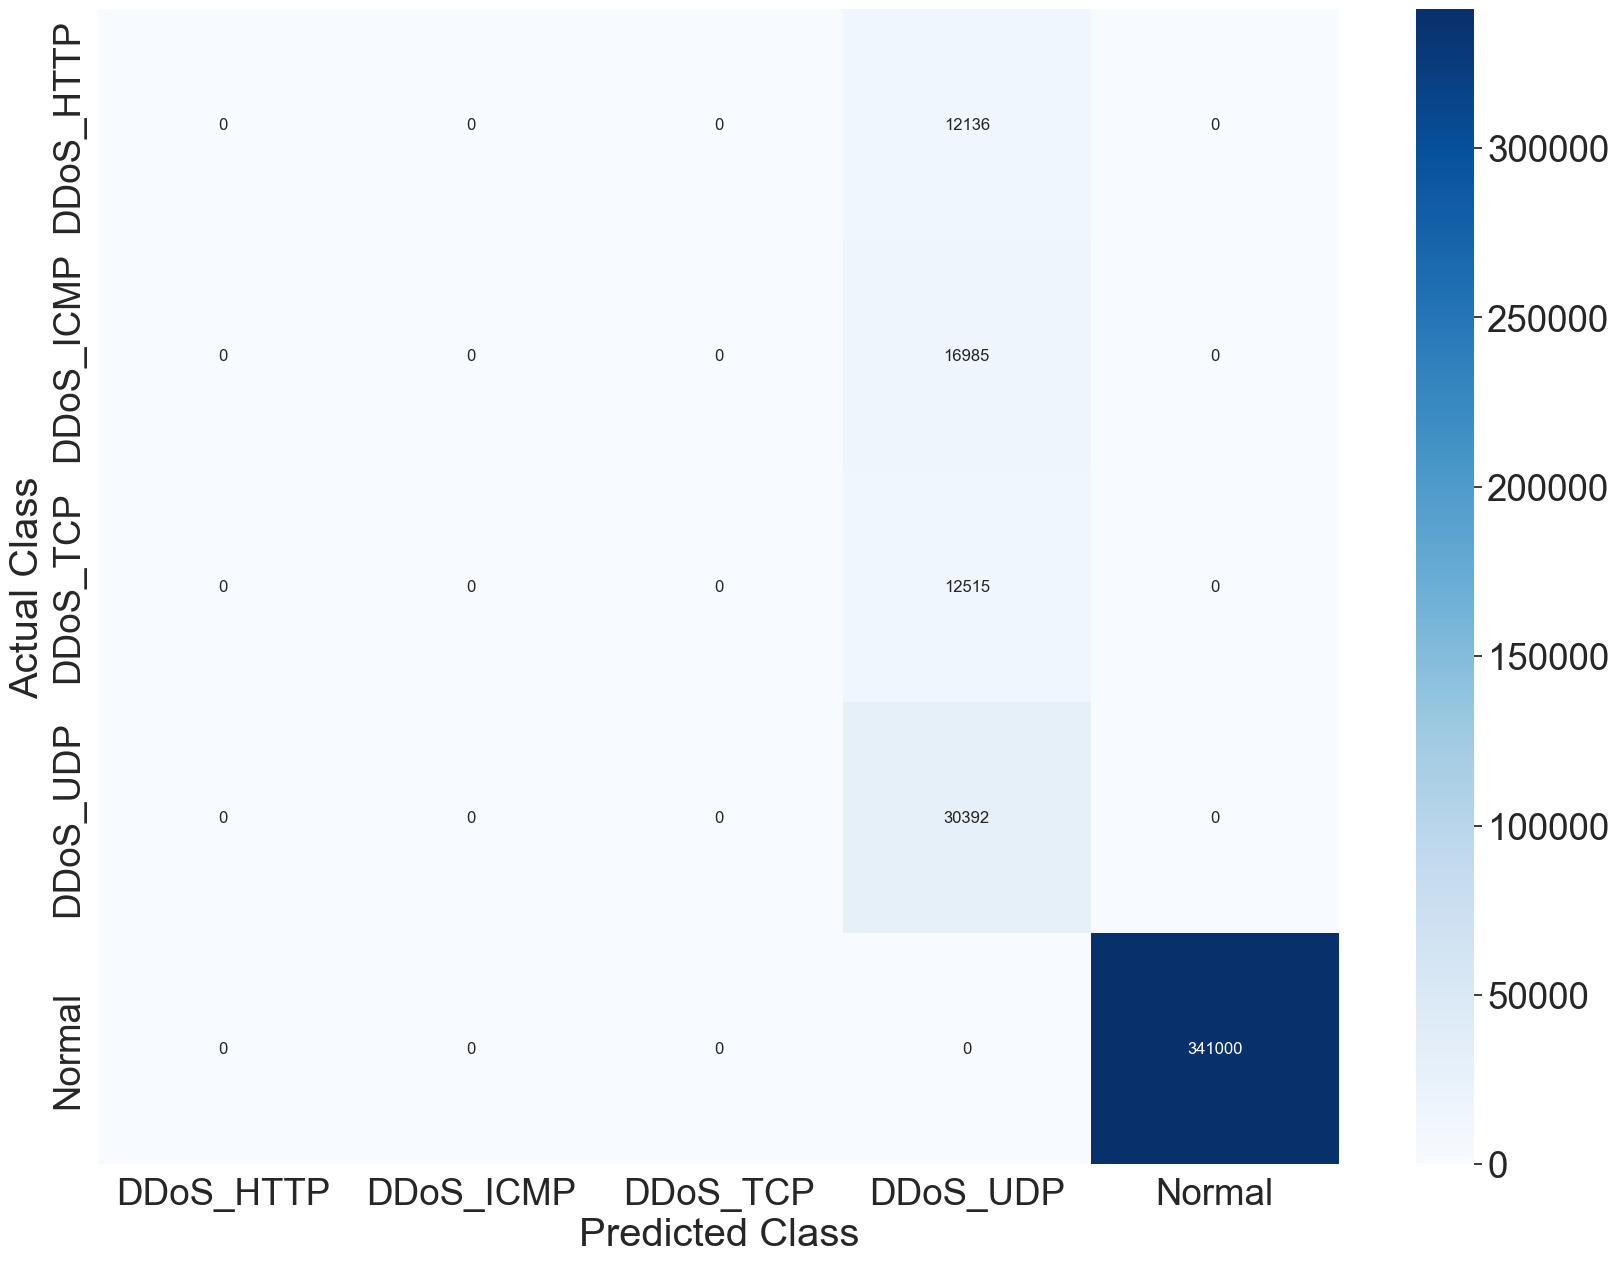

In [24]:
confMat = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(confMat)

labels = ['DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP', 'Normal']

plt.figure(figsize=(20,15))
sn.set(font_scale=2.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

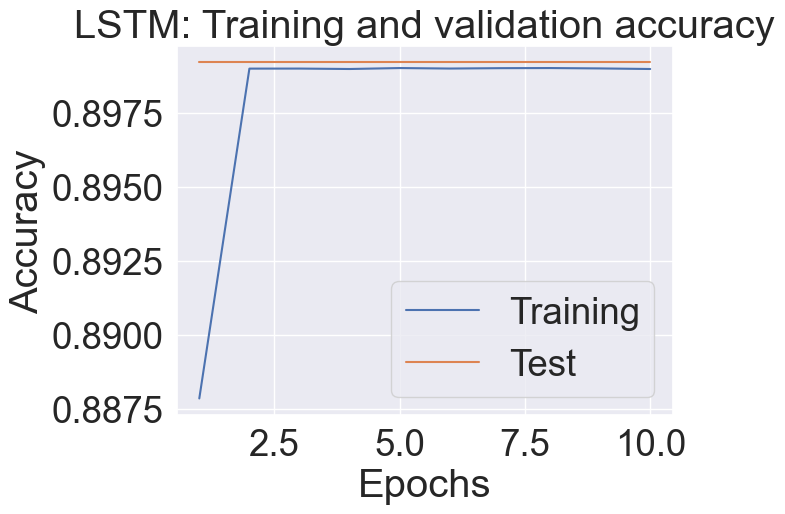

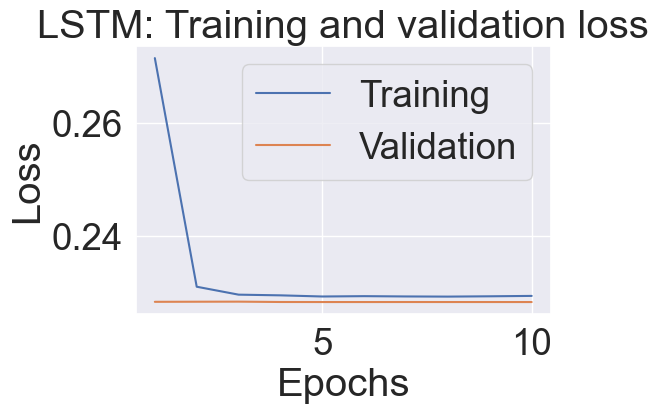

<Figure size 640x480 with 0 Axes>

In [25]:
start_epoch = 1
epochs = range(start_epoch, len(loss_values) + 1)

plt.plot(epochs, acc[start_epoch-1:], label='Training accuracy')
plt.plot(epochs, val_acc[start_epoch-1:], label='Validation accuracy')
plt.title('LSTM: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Test'], loc='lower right')

plt.show()
plt.clf()

plt.plot(epochs, loss_values[start_epoch-1:], label='Training Loss')
plt.plot(epochs, val_loss_values[start_epoch-1:], label='Validation Loss')
plt.title('LSTM: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.clf()